In [1]:
from random import *
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, Play, HBox, VBox, jslink
from oawidgets.plantgl import *
# try jupyter widgets

# from openalea.archicrop.cereals import build_shoot
from openalea.archicrop.plant_shape import compute_leaf_area_plant_from_params, check_LA_range, compute_leaf_area_growing_plant
from openalea.archicrop.simulation import retrieve_stics_dynamics_from_file, generate_and_display_plant, dict_ranges_to_all_possible_combinations, model
from openalea.archicrop.display import display_mtg, build_scene, display_scene
from openalea.archicrop.archicrop import ArchiCrop
# quasi MC sampling in scipy, cf latin hypercube
# SALiB

# Enable plotting with PlantGL
%gui qt
nice_green = Color3((50, 100, 0))

## Retrieve STICS dynamics from file

In [15]:
stics_output_file = 'mod_ssorghum.sti'
sowing_density = 10
inter_row = 0.4
stics_output_data = retrieve_stics_dynamics_from_file(stics_output_file, sowing_density)
height_potential_plant = max(value["Plant height"] for value in stics_output_data.values())
LAI_stics = [value["Plant leaf area"] for value in stics_output_data.values()]
time = [value["Thermal time"] for value in stics_output_data.values()]
# print(height_potential_plant)
# print(stics_output_data)

## Generate one potential plant from architectural parameters

In [3]:
# For sorghum
archi_params = dict(
    nb_phy = [10,20,30,40], # [10,15,20,25,30], 
    max_leaf_length = [60,80,100,120], 
    wl = 0.12, 
    diam_base = 2.5, 
    diam_top = 1.5, 
    insertion_angle = 30, # [10, 50], 
    scurv = 0.7, # [0.6, 0.8], 
    curvature = 90, # [45, 135], 
    alpha = -2.3, 
    stem_q = 1.1, 
    rmax = [0.7,0.8, 0.9], # 1-(1/3*(nb_phy - 5)/nb_phy)
    skew = [0.01,0.1], # 0.0005
    phyllotactic_angle = 180, 
    phyllotactic_deviation = 15, # [5, 30]
    phyllochron = [40,65],
    plastochron = [34,46],
    leaf_duration = [1,6],
    stem_duration = [1,6],
    leaf_senescence = [500, 1000]
)

In [4]:
[1-(1/3*(n - 5)/n) for n in archi_params["nb_phy"]] # for rmax = f(nb_phy)

[0.8333333333333334, 0.75, 0.7222222222222223, 0.7083333333333334]

In [5]:
def to_list(d):
    return {k: (v if isinstance(v, list) else [v]) for k,v in d.items()} 

archi_params = to_list(archi_params)

In [6]:
# slider on parameters with ranges, others fixed 
interact(generate_and_display_plant, 
         nb_phy=IntSlider(min=min(archi_params["nb_phy"]), 
                          max=max(archi_params["nb_phy"]), 
                          step=1, 
                          value=randint(archi_params["nb_phy"][0], archi_params["nb_phy"][-1])),
         height=fixed(height_potential_plant),
         max_leaf_length=IntSlider(min=min(archi_params["max_leaf_length"]), 
                                   max=max(archi_params["max_leaf_length"]), 
                                   step=1, 
                                   value=randint(archi_params["max_leaf_length"][0], archi_params["max_leaf_length"][-1])),
         wl=FloatSlider(min=min(archi_params["wl"]), 
                        max=max(archi_params["wl"]), 
                        step=0.01, 
                        value=choice(archi_params["wl"])),
         diam_base=fixed(archi_params["diam_base"][0]),
         diam_top=fixed(archi_params["diam_top"][0]),
         insertion_angle=IntSlider(min=min(archi_params["insertion_angle"]), 
                                   max=max(archi_params["insertion_angle"]), 
                                   step=1, 
                                   value=choice(archi_params["insertion_angle"])),
         scurv=FloatSlider(min=min(archi_params["scurv"]), 
                           max=max(archi_params["scurv"]), 
                           step=0.01, 
                           value=choice(archi_params["scurv"])),
         curvature=IntSlider(min=min(archi_params["curvature"]), 
                             max=max(archi_params["curvature"]), 
                             step=5, 
                             value=choice(archi_params["curvature"])),
         alpha=fixed(archi_params["alpha"][0]),
         stem_q=fixed(archi_params["stem_q"][0]),
         rmax=FloatSlider(min=min(archi_params["rmax"]), 
                          max=max(archi_params["rmax"]), 
                          step=0.01, 
                          value=0.75),
         skew=FloatSlider(min=min(archi_params["skew"]), 
                          max=max(archi_params["skew"]), 
                          step=0.01, 
                          value=0.05),
         phyllotactic_angle=fixed(archi_params["phyllotactic_angle"][0]),
         phyllotactic_deviation=IntSlider(min=min(archi_params["phyllotactic_deviation"]), 
                                          max=max(archi_params["phyllotactic_deviation"]), 
                                          step=5, 
                                          value=20))


# cf github openalea weberpenn trunk_parameters

interactive(children=(IntSlider(value=35, description='nb_phy', max=40, min=10), IntSlider(value=118, descript…

<function openalea.archicrop.simulation.generate_and_display_plant(nb_phy, height, max_leaf_length, wl, diam_base, diam_top, insertion_angle, scurv, curvature, alpha, stem_q, rmax, skew, phyllotactic_angle, phyllotactic_deviation)>

In [7]:
# take only the ones defined before
archi_params_combinations = dict_ranges_to_all_possible_combinations(archi_params)
print(len(archi_params_combinations))

# # Print combinations in the original order of dictionary keys
# for combo in archi_params_combinations:
#     print(combo)

3072


## Animation of growing plant 

In [9]:
# Fix a seed
seed(100)
nice_green = Color3((50, 100, 0))

# slider on parameters with ranges, others fixed 

height=height_potential_plant
nb_phy_slider=IntSlider(min=min(archi_params["nb_phy"]), max=max(archi_params["nb_phy"]), step=1, value=15)
max_leaf_length_slider=IntSlider(min=min(archi_params["max_leaf_length"]), max=max(archi_params["max_leaf_length"]), step=1, value=50)
wl_slider=FloatSlider(min=min(archi_params["wl"]), max=max(archi_params["wl"]), step=0.01, value=0.12)
diam_base_slider=fixed(archi_params["diam_base"][0])
diam_top_slider=fixed(archi_params["diam_top"][0])
insertion_angle_slider=IntSlider(min=min(archi_params["insertion_angle"]), max=max(archi_params["insertion_angle"]), step=1, value=30)
scurv_slider=FloatSlider(min=min(archi_params["scurv"]), max=max(archi_params["scurv"]), step=0.01, value=0.7)
curvature_slider=IntSlider(min=min(archi_params["curvature"]), max=max(archi_params["curvature"]), step=5, value=90)
alpha_slider=fixed(archi_params["alpha"][0])
stem_q_slider=fixed(archi_params["stem_q"][0])
rmax_slider=FloatSlider(min=min(archi_params["rmax"]), max=max(archi_params["rmax"]), step=0.01, value=0.8)
skew_slider=fixed(archi_params["skew"][0])
phyllotactic_angle_slider=fixed(archi_params["phyllotactic_angle"][0])
phyllotactic_deviation_slider=IntSlider(min=min(archi_params["phyllotactic_deviation"]), max=max(archi_params["phyllotactic_deviation"]), step=5, value=15)
phyllochron_slider=IntSlider(min=min(archi_params["phyllochron"]), max=max(archi_params["phyllochron"]), step=1, value=55)
plastochron_slider=IntSlider(min=min(archi_params["plastochron"]), max=max(archi_params["plastochron"]), step=1, value=40)
leaf_duration_slider=FloatSlider(min=min(archi_params["leaf_duration"]), max=max(archi_params["leaf_duration"]), step=0.1, value=6)
stem_duration_slider=FloatSlider(min=min(archi_params["stem_duration"]), max=max(archi_params["stem_duration"]), step=0.1, value=1.5)
leaf_senescence_slider=IntSlider(min=min(archi_params["leaf_senescence"]), max=max(archi_params["leaf_senescence"]), step=10, value=700)

time_slider = IntSlider(value=0, min=0, max=len(time), step=1, description="Time")

# Interactive widget setup
play_widget = Play(value=0, min=0, max=len(time), step=1, interval=1000)

# Link play widget with time slider
jslink((play_widget, 'value'), (time_slider, 'value'))

# Callback to update scene
def update_scene(*args):
    seed(100)
    nb_phy = nb_phy_slider.value
    max_leaf_length = max_leaf_length_slider.value
    wl = wl_slider.value
    diam_base = diam_base_slider.value
    diam_top = diam_top_slider.value
    insertion_angle = insertion_angle_slider.value
    scurv = scurv_slider.value
    curvature = curvature_slider.value
    alpha = alpha_slider.value
    stem_q = stem_q_slider.value
    rmax = rmax_slider.value
    skew = skew_slider.value
    phyllotactic_angle = phyllotactic_angle_slider.value
    phyllotactic_deviation = phyllotactic_deviation_slider.value
    phyllochron = phyllochron_slider.value
    plastochron = plastochron_slider.value
    leaf_duration = leaf_duration_slider.value
    stem_duration = stem_duration_slider.value
    leaf_senescence = leaf_senescence_slider.value
    time = time_slider.value
    sorghum = ArchiCrop(height, nb_phy, max_leaf_length, wl, diam_base, diam_top, insertion_angle, scurv, curvature, alpha, 
                        stem_q, rmax, skew, phyllotactic_angle, phyllotactic_deviation, 
                        phyllochron, plastochron, leaf_duration, stem_duration, leaf_senescence)
    sorghum.generate_potential_plant()
    sorghum.define_development()
    growing_plant = sorghum.grow_plant(stics_output_data)
    Viewer.display(build_scene(growing_plant[time], leaf_material = Material(nice_green), stem_material=Material(nice_green))[0])
    # PlantGL(build_scene(growing_plant[time]))

# Attach update callback
nb_phy_slider.observe(update_scene, names='value')
max_leaf_length_slider.observe(update_scene, names='value')
insertion_angle_slider.observe(update_scene, names='value')
scurv_slider.observe(update_scene, names='value')
curvature_slider.observe(update_scene, names='value')
time_slider.observe(update_scene, names='value')

# Display widgets
controls = VBox([nb_phy_slider, max_leaf_length_slider, insertion_angle_slider, scurv_slider, curvature_slider, HBox([time_slider, play_widget])])
display(controls)

# Initial scene display
update_scene()

# cf github openalea weberpenn trunk_parameters

In [19]:
def parametric_model_sorghum(time, max_leaf_length, rmax, skew, phyllochron, plastochron, leaf_duration, stem_duration):
    """
    Define parametric model.

    Args:
    - max_leaf_length, phyllochron: Parameters of the model

    Returns:
    - leaf_areas: Output values corresponding to the model
    """

    sorghum = ArchiCrop(height=222, # from crop model
                        nb_phy=25,
                        max_leaf_length=max_leaf_length,
                        wl=0.12, diam_base=2.5, diam_top=1.5, 
                        insertion_angle=30, scurv=0.7, curvature=100, 
                        alpha=-2.3, stem_q=1.1, rmax=rmax, skew=skew, # 0.0005
                        phyllotactic_angle=180,
                        phyllotactic_deviation=15,
                        phyllochron=phyllochron, 
                        plastochron=plastochron, 
                        leaf_duration=leaf_duration, 
                        stem_duration=stem_duration, 
                        leaf_senescence=800)
    sorghum.generate_potential_plant()
    sorghum.define_development()
    growing_plant = sorghum.grow_plant(stics_output_data)

    return [sum(compute_leaf_area_growing_plant(gp)) for gp in growing_plant]

                  Max leaf length  Leaf duration
Optimized parameters: [92.07654878  0.60000131  0.1        50.         50.          5.5
  5.5       ]
Covariances: [[ 4.05509955e-12 -1.54735164e-08 -1.77363194e-09  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.54735164e-08  5.66486478e-04  4.23165304e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.77363194e-09  4.23165304e-04  3.44064797e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Standard errors:

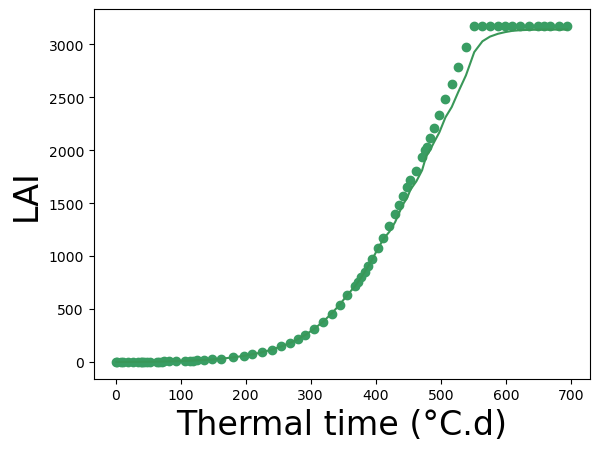

In [20]:
from scipy.optimize import curve_fit

# Fit the model to crop model data and obtain optimal parameters
optimal_params, covariance = curve_fit(f=parametric_model_sorghum, xdata=time, ydata=LAI_stics, bounds=([20,0.6,0.0005,30,30,1,1],[120,0.8,0.1,70,70,10,10]), method='trf') # bounds to set from lit
se = np.sqrt(np.diag(covariance))

print("                  Max leaf length  Leaf duration")
print("Optimized parameters:", optimal_params)
print("Covariances:", covariance)
print("Standard errors:", se)

# Visualize the fit
plt.clf()
plt.scatter(time, LAI_stics, color=(57/255,157/255,99/255), label='Simulation with STICS') # R 243, G 146, B 0
res = parametric_model_sorghum(time, *optimal_params)
plt.plot(time, np.array(res), color=(57/255,151/255,88/255), label='Simulation with ArchiCrop') # R 57, G 151, B 88
plt.xlabel('Thermal time (°C.d)', fontsize=24)
plt.ylabel('LAI', fontsize=24)
# plt.legend()
plt.show()

In [18]:
time_slider = IntSlider(value=0, min=0, max=len(time), step=1, description="Time")

# Interactive widget setup
play_widget = Play(value=0, min=0, max=len(time), step=1, interval=500)

# Link play widget with time slider
jslink((play_widget, 'value'), (time_slider, 'value'))

# Callback to update scene
def update_scene(*args):
    time = time_slider.value
    Viewer.display(gp_scenes[time])

# Attach update callback
time_slider.observe(update_scene, names='value')

# Display widgets
controls = HBox([time_slider, play_widget])
display(controls)

# Initial scene display
update_scene()

# cf github openalea weberpenn trunk_parameters

NameError: name 'gp_scenes' is not defined

In [17]:
def parametric_model_sorghum_nb_phy(time, max_leaf_length, nb_phy):
    """
    Define parametric model.

    Args:
    - max_leaf_length, phyllochron: Parameters of the model

    Returns:
    - leaf_areas: Output values corresponding to the model
    """

    sorghum = ArchiCrop(height=222, # from crop model
                        nb_phy=nb_phy,
                        max_leaf_length=max_leaf_length,
                        wl=0.12, diam_base=2.5, diam_top=1.5, 
                        insertion_angle=30, scurv=0.7, curvature=100, 
                        alpha=-2.3, stem_q=1.1, rmax=0.75, skew=0.08, # 0.0005
                        phyllotactic_angle=180,
                        phyllotactic_deviation=15, phyllochron=55, plastochron=45, leaf_duration=5, stem_duration=2, leaf_senescence=800)
    sorghum.generate_potential_plant()
    sorghum.define_development()
    growing_plant = sorghum.grow_plant(g, stics_output_data)

    return [sum(compute_leaf_area_growing_plant(gp)) for gp in growing_plant]

best_params = None
best_error = float('inf')

# Grid search over integer values for nb_phy
for nb_phy in range(10, 36, 5):  # Integer bounds for nb_phy
    def model_with_fixed_nb_phy(time, max_leaf_length):
        return parametric_model_sorghum_nb_phy(time, max_leaf_length, nb_phy)
    
    try:
        params, _ = curve_fit(
            f=model_with_fixed_nb_phy,
            xdata=time,
            ydata=LAI_stics,
            bounds=([20], [120]),  # Bounds for max_leaf_length only
            method='trf'
        )
        error = np.sum((LAI_stics - model_with_fixed_nb_phy(time, params[0]))**2)
        if error < best_error:
            best_error = error
            best_params = [params[0], nb_phy]
            print(best_params)
    except:
        continue